 # 目标检测/物体检测 和图片分类的区别

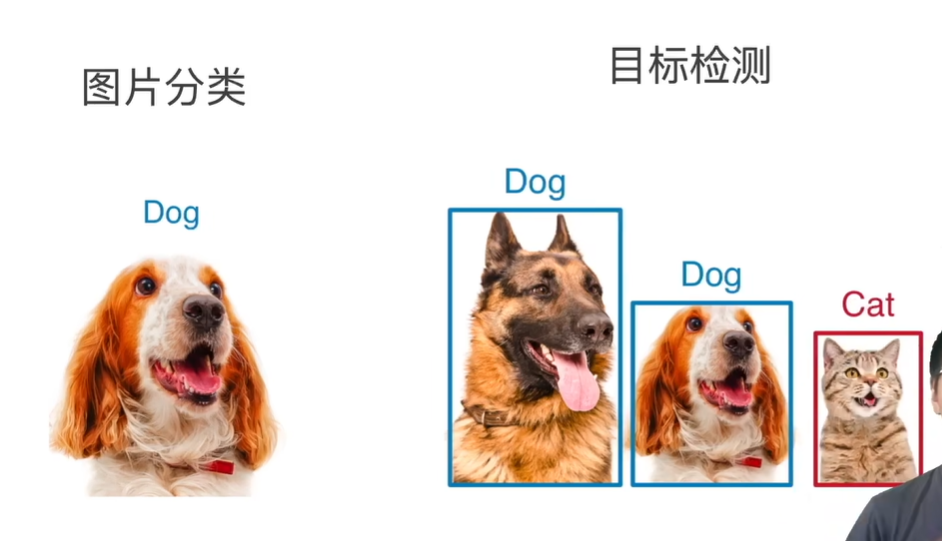
不仅要找到图片中所有猫和狗（多个物体的识别） 还要找到其位置 （当图片中只有一个物体时就又变成了图片分类）

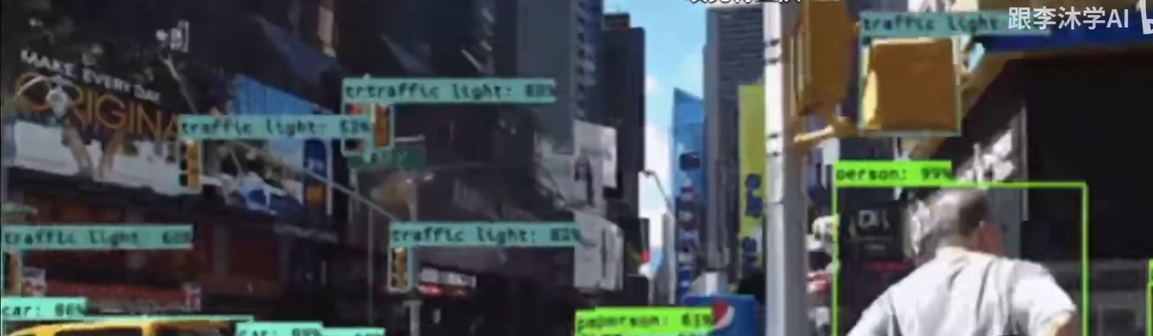

# 边缘框

表示一个物体的位置

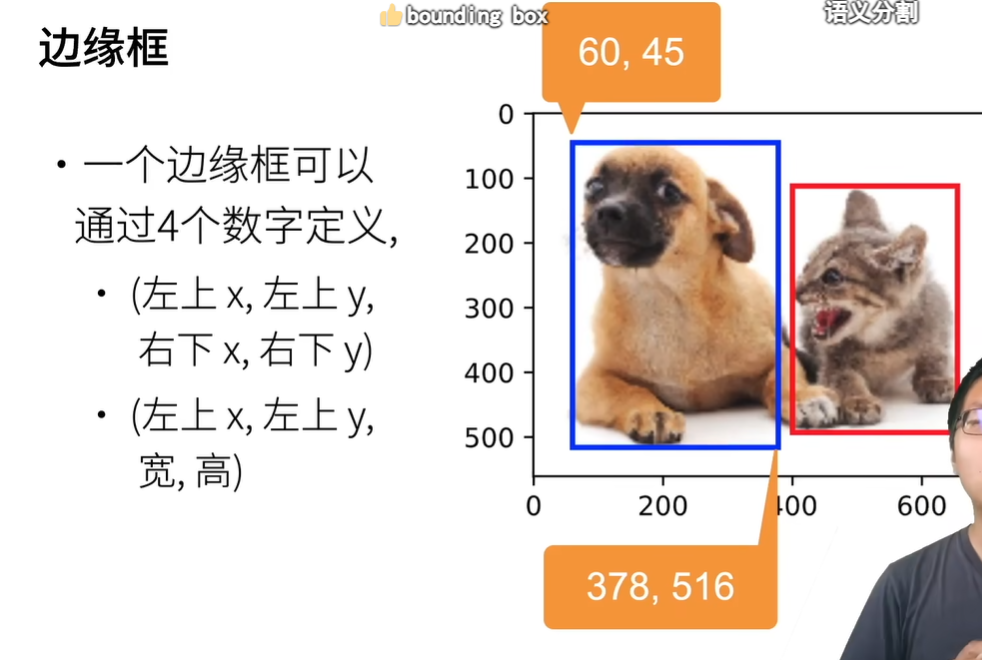

用4个数字来表示一个边缘 4个数字即预测的目标

# 目标检测数据集

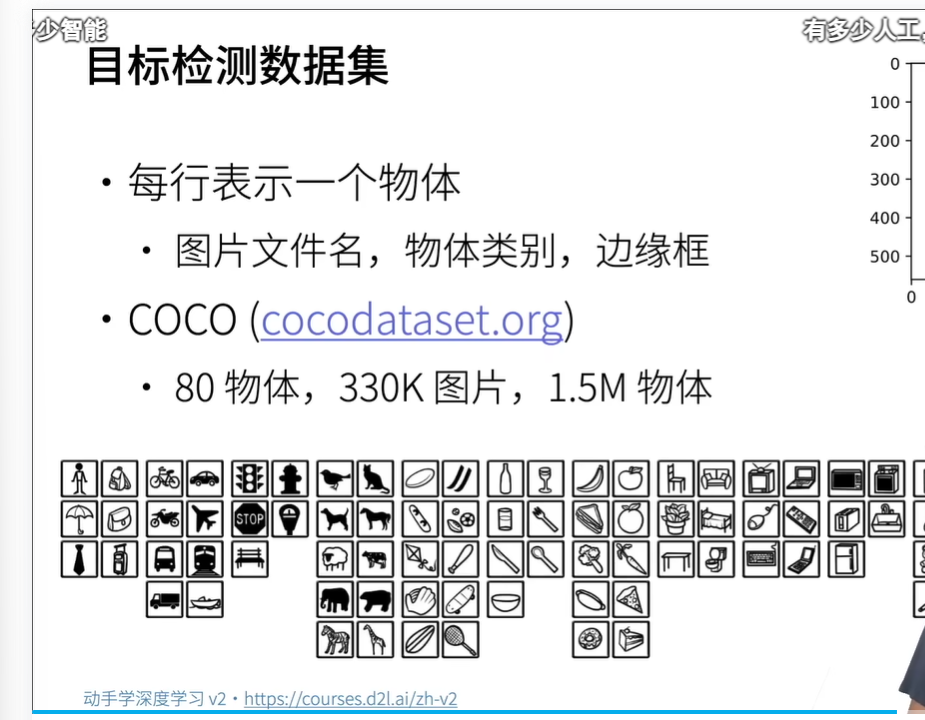

类别数少于分类数据集但 每张图片中有多个物体

# 总结

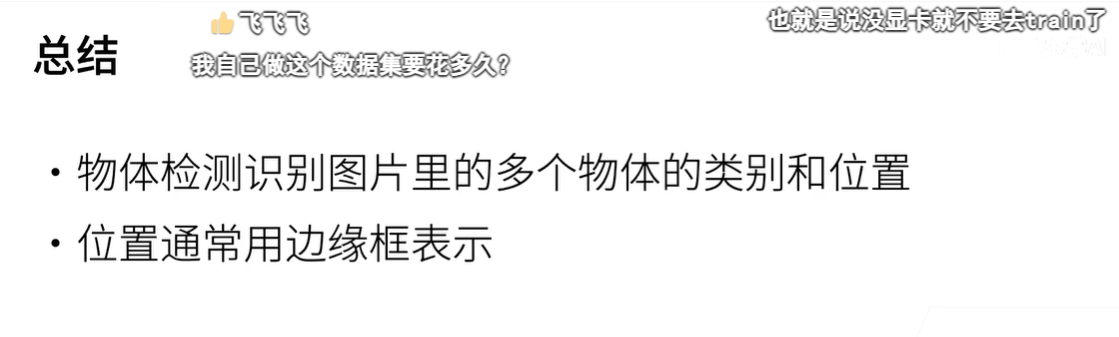

In [3]:
# 边缘框的实现
# %matplotlib inline
import torch
from d2l import torch as d2l

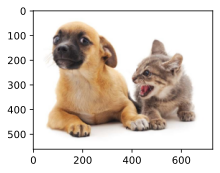

In [4]:
d2l.set_figsize()
img = d2l.plt.imread('catdog.jpg')
d2l.plt.imshow(img)

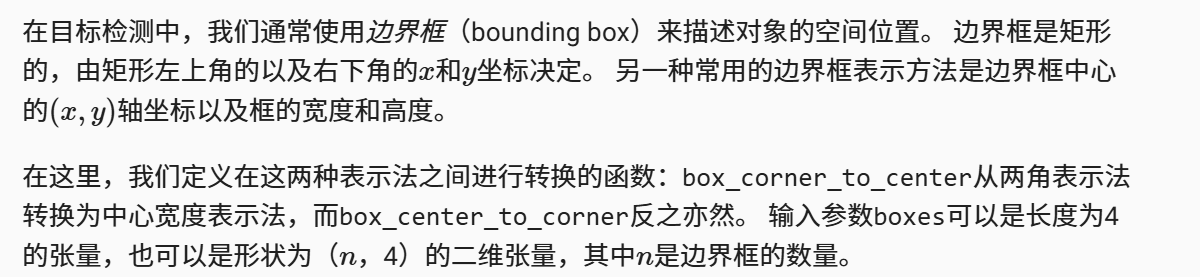

In [5]:
# 这两个函数的主要作用是进行边界框的坐标转换。目标检测中常用的边界框表示有两种：
# 一种是用左上角和右下角的坐标表示（corner coordinates），
# 另一种是用中心点坐标以及宽度和高度表示（center coordinates）。
# 这两个函数分别实现了这两种表示的互相转换。


# boxes：形状为 (n, 4) 的张量，其中 n 是边界框的数量。
# 每个边界框用 (x1, y1, x2, y2) 表示，其中 (x1, y1) 
# 是左上角坐标，(x2, y2) 是右下角坐标。


# 输出：
# 返回一个形状为 (n, 4) 的张量，其中每个边界框用 (cx, cy, w, h) 表示，
# 分别是中心点的坐标 (cx, cy) 以及宽度和高度 (w, h)。

#@save
def box_corner_to_center(boxes):
    """从（左上，右下）转换到（中间，宽度，高度）"""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    """从（中间，宽度，高度）转换到（左上，右下）"""
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [6]:
# bbox是边界框的英文缩写  定义狗和猫的边界框

dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [9]:
# 通过转换两次来验证边界框转换函数的正确性
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

In [10]:
# 我们可以将边界框在图中画出，以检查其是否准确。 画之前，
# 我们定义一个辅助函数bbox_to_rect。 它将边界框表示成matplotlib的边界框格式。
#@save
def bbox_to_rect(bbox, color):
    # 将边界框(左上x,左上y,右下x,右下y)格式转换成matplotlib格式：
    # ((左上x,左上y),宽,高)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

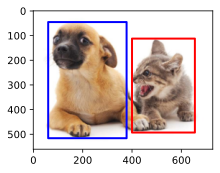

In [11]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

In [12]:
# 目标检测数据集
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

图片标签的文件

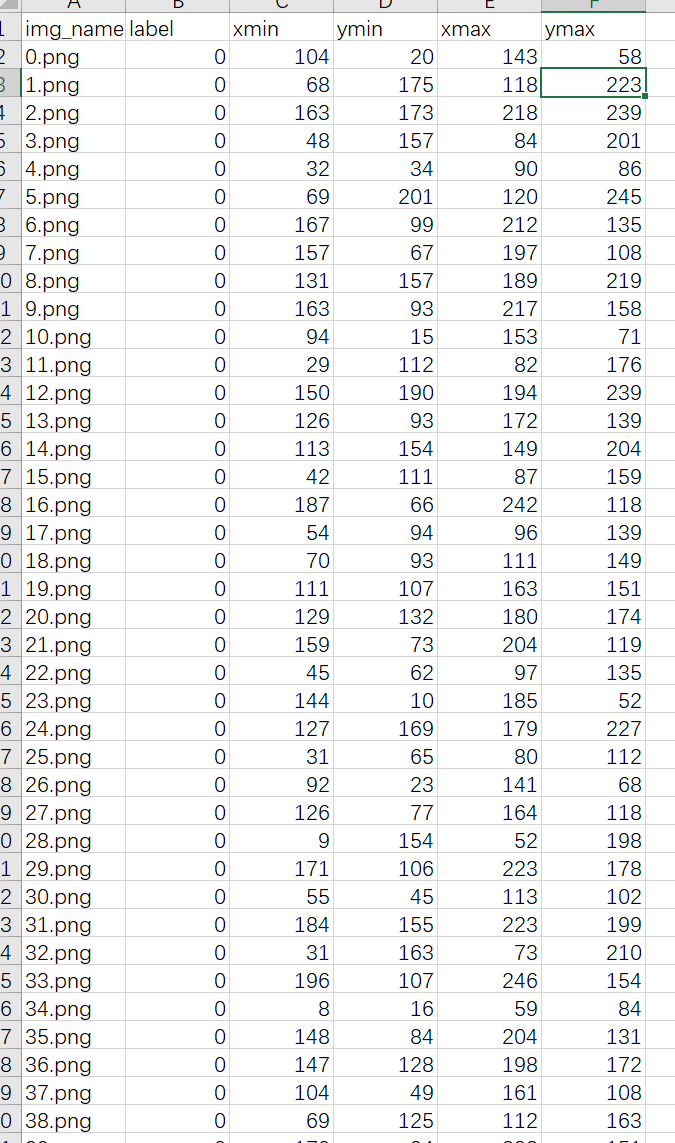

In [14]:
# 读取香蕉的数据集
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    
    # 下载并解压数据集
    data_dir = d2l.download_extract('banana-detection')
    
    # 根据是否是训练集，确定csv文件的路径
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    
    # 读取csv文件
    csv_data = pd.read_csv(csv_fname)
    
    # 将图像名称列设置为索引
    csv_data = csv_data.set_index('img_name')
    
    # 初始化图像和目标列表
    images, targets = [], []
    
    # 遍历csv中的每一行
    for img_name, target in csv_data.iterrows():
        # 读取图像，并添加到图像列表中
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        
        # target包含（类别，左上角x，左上角y，右下角x，右下角y）
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    
    # 将targets转换为tensor，并调整尺寸
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [15]:
# 创建一个Dataset的实例
#@save
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        # 读取香蕉检测数据集的特征和标签
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))
    
    def __getitem__(self, idx):
        # 返回索引idx对应的图像及其标签
        return (self.features[idx].float(), self.labels[idx])
    
    # 返回数据集的长度
    def __len__(self):
        return len(self.features)

In [16]:
#@save 们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。
# 对于测试集，无须按随机顺序读取它。
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [23]:
# 读取一个小批量 并打印其中图像和标签的形状
# 设置批次大小和图像尺寸
batch_size, edge_size = 32, 256

# 加载训练数据
train_iter, _ = load_data_bananas(batch_size)

# 获取一个批次的数据
batch = next(iter(train_iter))

# 输出图像和标签数据的形状
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

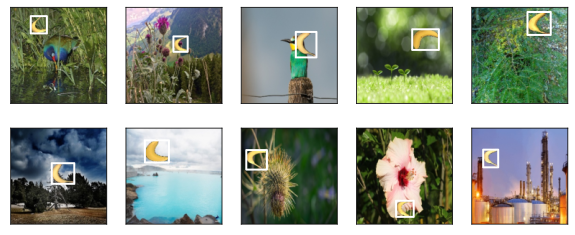

In [24]:
#看是否能正确输出图片和边框

imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])